# Advanced Models for Popularity Prediction
This notebook implements Random Forest and Gradient Boosting models for predicting song popularity, comparing them against the baseline Ridge regression model.

**Models:**
1. Ridge Regression (Baseline)
2. Random Forest Regressor
3. Gradient Boosting Regressor
4. XGBoost (optional, if available)

**Evaluation Metrics:** RMSE, $R^2$, Feature Importance


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Step 1: Load and Prepare Data


In [22]:
# Load data
df = pd.read_csv("../data/dataset.csv")
df = df.drop_duplicates(subset=["track_id"]).reset_index(drop=True)
print("Dataset loaded successfully")
print("Shape:", df.shape)
df.head()

Dataset loaded successfully
Shape: (89741, 21)


,index,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Step 2: Define Features and Target


In [37]:
# target variable
TARGET = "popularity"
# numeric audio features
audio_features = [
    "duration_ms", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness",
    "valence", "tempo", "time_signature"
]

# categorical features
categorical_features = ["explicit", "track_genre"]
keep_cols = ["track_id", "track_name", "artists", "album_name", TARGET] + audio_features + categorical_features
df = df[keep_cols].copy()

print("Missing values:")
print(df.isna().mean().sort_values(ascending=False).head(10))
print(f"\nDataset shape: {df.shape}")
print(f"Target variable: {TARGET}")
print(f"Audio features: {len(audio_features)}")
print(f"Categorical features: {len(categorical_features)}")

Missing values:
track_name      0.000011
artists         0.000011
album_name      0.000011
track_id        0.000000
popularity      0.000000
duration_ms     0.000000
danceability    0.000000
energy          0.000000
key             0.000000
loudness        0.000000
dtype: float64

Dataset shape: (89741, 20)
Target variable: popularity
Audio features: 13
Categorical features: 2


## Step 3: Train/Test Split


In [38]:
# Prepare features and target
X = df[audio_features + categorical_features]
y = df[TARGET].astype(float)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")
print(f"\nTarget statistics (train):")
print(y_train.describe())
print(f"\nTarget statistics (test):")
print(y_test.describe())

Train size: (71792, 15)
Test size: (17949, 15)

Target statistics (train):
count    71792.000000
mean        33.234441
std         20.616349
min          0.000000
25%         19.000000
50%         33.000000
75%         49.000000
max        100.000000
Name: popularity, dtype: float64

Target statistics (test):
count    17949.000000
mean        33.054432
std         20.438051
min          0.000000
25%         19.000000
50%         33.000000
75%         48.000000
max         97.000000
Name: popularity, dtype: float64


## Step 4: Preprocessing Pipeline


In [39]:
# Numeric preprocessing: impute missing values + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing: impute + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine numeric + categorical preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, audio_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

## Step 5: Baseline Model - Ridge Regression


In [40]:
# Ridge Regression as baseline
ridge_model = Ridge(alpha=3.0, random_state=42)

ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ridge_model)
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"Ridge Regression")
print(f"RMSE: {rmse_ridge:.3f}")
print(f"R^2: {r2_ridge:.3f}")
print(f"MAE: {mae_ridge:.3f}")

results = {"Ridge": {"RMSE": rmse_ridge, "R^2": r2_ridge, "MAE": mae_ridge}}

Ridge Regression
RMSE: 16.844
R^2: 0.321
MAE: 12.017


## Step 6: Random Forest Model


In [41]:
# Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model)
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R^2: {r2_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")

results["Random Forest"] = {"RMSE": rmse_rf, "R^2": r2_rf, "MAE": mae_rf}

Random Forest
RMSE: 18.376
R^2: 0.192
MAE: 14.529


## Step 7: Gradient Boosting Model


In [42]:
# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    verbose=0
)

gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", gb_model)
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting")
print(f"RMSE: {rmse_gb:.3f}")
print(f"R^2: {r2_gb:.3f}")
print(f"MAE: {mae_gb:.3f}")
results["Gradient Boosting"] = {"RMSE": rmse_gb, "R^2": r2_gb, "MAE": mae_gb}

Gradient Boosting
RMSE: 17.105
R^2: 0.300
MAE: 13.197


## Step 8: XGBoost Model (Optional)


In [43]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_model)
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost")
print(f"RMSE: {rmse_xgb:.3f}")
print(f"R^2: {r2_xgb:.3f}")
print(f"MAE: {mae_xgb:.3f}")
results["XGBoost"] = {"RMSE": rmse_xgb, "R^2": r2_xgb, "MAE": mae_xgb}

XGBoost
RMSE: 17.058
R^2: 0.303
MAE: 13.168


## Step 9: Model Comparison


MODEL COMPARISON
                     RMSE    R^2     MAE
Ridge              16.844  0.321  12.017
XGBoost            17.058  0.303  13.168
Gradient Boosting  17.105  0.300  13.197
Random Forest      18.376  0.192  14.529


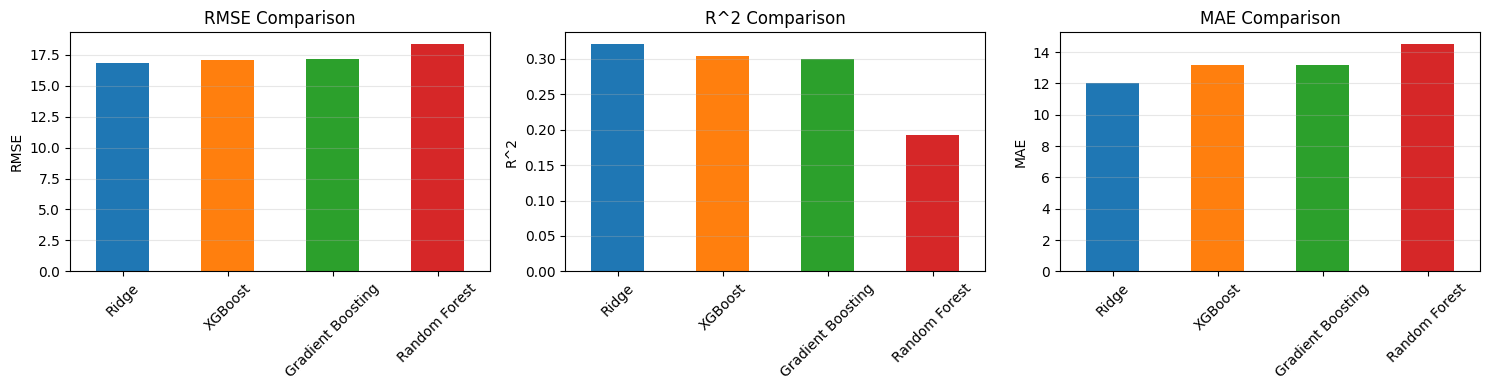

In [44]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(3)
comparison_df = comparison_df.sort_values("RMSE")

print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)
print(comparison_df.to_string())
print("=" * 50)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['RMSE', 'R^2', 'MAE']
for idx, metric in enumerate(metrics):
    comparison_df[metric].plot(kind='bar', ax=axes[idx], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(comparison_df)])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 10: Feature Importance Analysis


Total number of features after preprocessing: 128


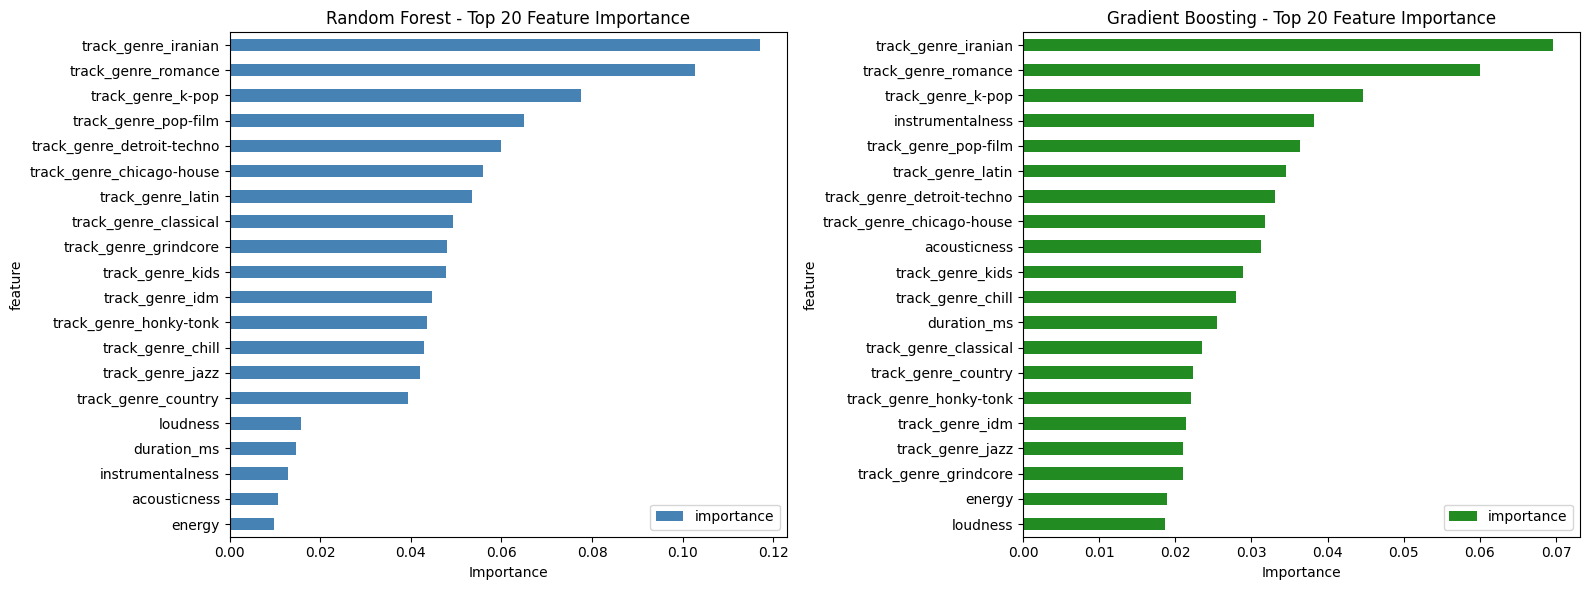

Top 10 Features - Random Forest:
                   feature  importance
       track_genre_iranian    0.117069
       track_genre_romance    0.102742
         track_genre_k-pop    0.077501
      track_genre_pop-film    0.064932
track_genre_detroit-techno    0.059796
 track_genre_chicago-house    0.055937
         track_genre_latin    0.053426
     track_genre_classical    0.049196
     track_genre_grindcore    0.047926
          track_genre_kids    0.047741

Top 10 Features - Gradient Boosting:
                   feature  importance
       track_genre_iranian    0.069674
       track_genre_romance    0.060034
         track_genre_k-pop    0.044618
          instrumentalness    0.038190
      track_genre_pop-film    0.036316
         track_genre_latin    0.034534
track_genre_detroit-techno    0.033108
 track_genre_chicago-house    0.031713
              acousticness    0.031187
          track_genre_kids    0.028867


In [45]:
# Get feature names after preprocessing
# Use the fitted preprocess from the pipeline (already fitted during model training)
fitted_preprocess = rf_pipeline.named_steps['preprocess']
feature_names = (
    audio_features + 
    list(fitted_preprocess.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
)

print(f"Total number of features after preprocessing: {len(feature_names)}")

# Random Forest Feature Importance
rf_importances = rf_pipeline.named_steps['model'].feature_importances_
rf_feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=False).head(20)

# Gradient Boosting Feature Importance
gb_importances = gb_pipeline.named_steps['model'].feature_importances_
gb_feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_importances
}).sort_values('importance', ascending=False).head(20)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
rf_feat_df.plot(x='feature', y='importance', kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Random Forest - Top 20 Feature Importance')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

# Gradient Boosting
gb_feat_df.plot(x='feature', y='importance', kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title('Gradient Boosting - Top 20 Feature Importance')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Top 10 Features - Random Forest:")
print(rf_feat_df.head(10).to_string(index=False))
print("\nTop 10 Features - Gradient Boosting:")
print(gb_feat_df.head(10).to_string(index=False))


## Step 11: Hyperparameter Tuning (Random Forest)


In [ ]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 15, 20, None],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [2, 4, 6],
    'model__max_features': ['sqrt', 'log2', None]
}

rf_pipeline_tune = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_random_search = RandomizedSearchCV(
    rf_pipeline_tune,
    rf_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random_search.fit(X_train, y_train)
print("\nBest parameters for Random Forest:")
print(rf_random_search.best_params_)

# Evaluate best model
y_pred_rf_tuned = rf_random_search.predict(X_test)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f"\nRandom Forest - Tuned")
print(f"RMSE: {rmse_rf_tuned:.3f}")
print(f"R^2: {r2_rf_tuned:.3f}")
print(f"Improvement over baseline: RMSE reduction = {rmse_ridge - rmse_rf_tuned:.3f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for Random Forest:
{'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': None}

[Random Forest - Tuned]
RMSE: 14.895
R^2: 0.469
Improvement over baseline: RMSE reduction = 1.949


## Step 12: Hyperparameter Tuning (Gradient Boosting)


In [48]:
# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.05, 0.1, 0.15],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [2, 4, 6],
    'model__subsample': [0.8, 0.9, 1.0]
}

gb_pipeline_tune = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(random_state=42))
])

print("Starting RandomizedSearchCV for Gradient Boosting...")
print("This may take several minutes...")

gb_random_search = RandomizedSearchCV(
    gb_pipeline_tune,
    gb_param_grid,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

gb_random_search.fit(X_train, y_train)

print("\nBest parameters for Gradient Boosting:")
print(gb_random_search.best_params_)

# Evaluate best model
y_pred_gb_tuned = gb_random_search.predict(X_test)
rmse_gb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_gb_tuned))
r2_gb_tuned = r2_score(y_test, y_pred_gb_tuned)

print(f"\n[Gradient Boosting - Tuned]")
print(f"RMSE: {rmse_gb_tuned:.3f}")
print(f"R^2: {r2_gb_tuned:.3f}")
print(f"Improvement over baseline: RMSE reduction = {rmse_ridge - rmse_gb_tuned:.3f}")


Starting RandomizedSearchCV for Gradient Boosting...
This may take several minutes...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for Gradient Boosting:
{'model__subsample': 0.9, 'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 6, 'model__max_depth': 7, 'model__learning_rate': 0.15}

[Gradient Boosting - Tuned]
RMSE: 15.301
R^2: 0.439
Improvement over baseline: RMSE reduction = 1.543


## Step 13: Final Model Comparison (Including Tuned Models)


FINAL MODEL COMPARISON (All Models)
                               RMSE    R^2     MAE
Random Forest (Tuned)        14.895  0.469  10.195
Gradient Boosting (Tuned)    15.301  0.439  10.595
Ridge (Baseline)             16.844  0.321  12.017
XGBoost                      17.058  0.303  13.168
Gradient Boosting (Default)  17.105  0.300  13.197
Random Forest (Default)      18.376  0.192  14.529


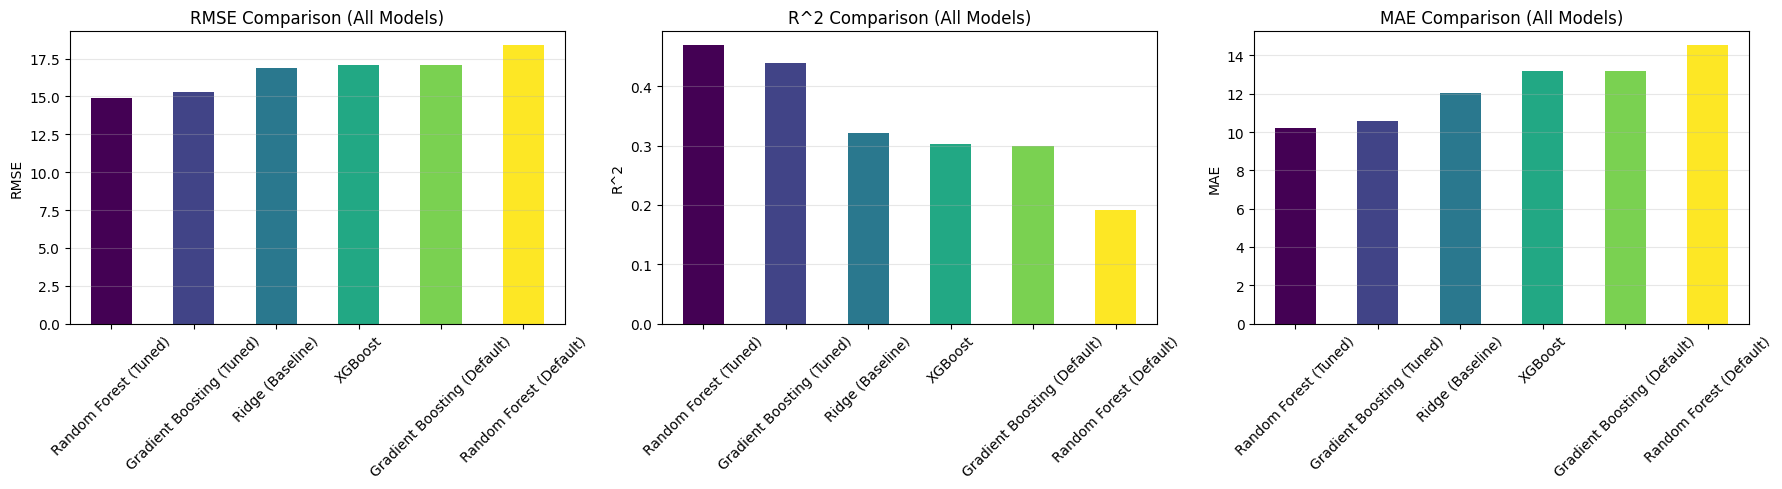


 Best Model: Random Forest (Tuned)
   RMSE: 14.895
   R^2: 0.469
   Improvement over Ridge baseline: 11.6%


In [51]:
# Final results including tuned models
final_results = {
    "Ridge (Baseline)": {"RMSE": rmse_ridge, "R^2": r2_ridge, "MAE": mae_ridge},
    "Random Forest (Default)": {"RMSE": rmse_rf, "R^2": r2_rf, "MAE": mae_rf},
    "Random Forest (Tuned)": {"RMSE": rmse_rf_tuned, "R^2": r2_rf_tuned, "MAE": mean_absolute_error(y_test, y_pred_rf_tuned)},
    "Gradient Boosting (Default)": {"RMSE": rmse_gb, "R^2": r2_gb, "MAE": mae_gb},
    "Gradient Boosting (Tuned)": {"RMSE": rmse_gb_tuned, "R^2": r2_gb_tuned, "MAE": mean_absolute_error(y_test, y_pred_gb_tuned)},
    "XGBoost": {"RMSE": rmse_xgb, "R^2": r2_xgb, "MAE": mae_xgb}
}

final_comparison_df = pd.DataFrame(final_results).T
final_comparison_df = final_comparison_df.round(3)
final_comparison_df = final_comparison_df.sort_values("RMSE")

print("=" * 60)
print("FINAL MODEL COMPARISON (All Models)")
print("=" * 60)
print(final_comparison_df.to_string())
print("=" * 60)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    final_comparison_df[metric].plot(kind='bar', ax=axes[idx], 
                                     color=plt.cm.viridis(np.linspace(0, 1, len(final_comparison_df))))
    axes[idx].set_title(f'{metric} Comparison (All Models)')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Find best model
best_model_name = final_comparison_df.index[0]
best_rmse = final_comparison_df.loc[best_model_name, 'RMSE']
print(f"\n Best Model: {best_model_name}")
print(f"   RMSE: {best_rmse:.3f}")
print(f"   R^2: {final_comparison_df.loc[best_model_name, 'R^2']:.3f}")
print(f"   Improvement over Ridge baseline: {((rmse_ridge - best_rmse) / rmse_ridge * 100):.1f}%")


## Step 14: Prediction Visualization


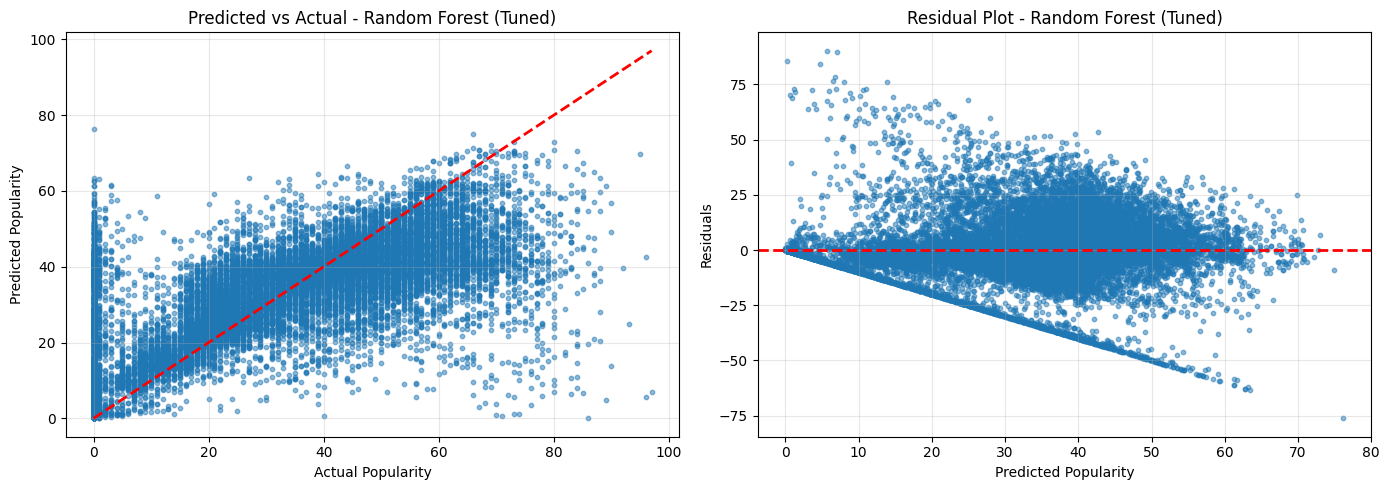

Residual statistics for Random Forest (Tuned):
  Mean: 0.313
  Std: 14.892
  Min: -76.221
  Max: 90.300


In [ ]:
# Visualize predictions vs actual values for best model
if 'Random Forest (Tuned)' in final_comparison_df.index:
    best_predictions = y_pred_rf_tuned
    best_name = "Random Forest (Tuned)"
elif 'Gradient Boosting (Tuned)' in final_comparison_df.index:
    best_predictions = y_pred_gb_tuned
    best_name = "Gradient Boosting (Tuned)"
else:
    best_predictions = y_pred_rf
    best_name = "Random Forest"

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, best_predictions, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Popularity')
axes[0].set_ylabel('Predicted Popularity')
axes[0].set_title(f'Predicted vs Actual - {best_name}')
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Popularity')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'Residual Plot - {best_name}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual statistics for {best_name}:")
print(f"  Mean: {residuals.mean():.3f}")
print(f"  Std: {residuals.std():.3f}")
print(f"  Min: {residuals.min():.3f}")
print(f"  Max: {residuals.max():.3f}")

## Summary

This notebook implemented and compared several advanced models for song popularity prediction:

1. **Baseline (Ridge Regression)**: Linear model with L2 regularization
2. **Random Forest**: Ensemble of decision trees, good for capturing non-linear relationships
3. **Gradient Boosting**: Sequential ensemble method that builds trees to correct errors
4. **XGBoost** (if available): Optimized gradient boosting implementation

**Key Findings:**
- Tree-based models (Random Forest, Gradient Boosting) generally outperform linear models
- Hyperparameter tuning improves model performance
- Feature importance analysis reveals which audio features are most predictive
- Genre features remain important for cold-start popularity prediction

**Next Steps:**
- Consider ensemble methods (voting or stacking)
- Integrate best model into recommendation system
- Evaluate on different subsets of data (by genre, time period, etc.)
